In [ ]:
%matplotlib inline


# Global Akida workflow

.. Note:: Please refer to the TensorFlow  [tf.keras.models](https://www.tensorflow.org/api_docs/python/tf/keras/models)_
          module for model creation/import details and the [TensorFlow Guide](https://www.tensorflow.org/guide)_ for TensorFlow usage.

## 1. Create and train




### Imports

In [1]:
import os

import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from keras.optimizers import Adam
import numpy as np

2024-11-12 18:34:26.783825: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 18:34:27.217428: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 18:34:27.217556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 18:34:27.282490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 18:34:27.417924: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 18:34:27.420170: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
from keras_mobilnet_v1.py import PoseEstimationLoss

### 1.1. Load and reshape projection dataset



(120, 7)
(120, 240, 240, 3)


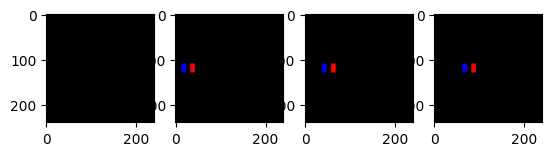

In [ ]:


# import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt

#TODO: import the dataset

#TODO: Load projection dataset
# x_test, y_test = ...

# import csv
position_dir = './event_frames'
# position_file = 'position.csv'
# # Load position data from CSV
y_train = tf.convert_to_tensor(list(range(7)), dtype=tf.float32)
y_train = tf.expand_dims(y_train, axis=1)
y_train = tf.tile(y_train, [1, 200])
y_train = tf.transpose(y_train, perm=[1, 0])
print(y_train.shape)
# with open(os.path.abspath(os.path.join(position_dir, position_file))) as file:
#     reader = csv.reader(file)
#     for row in reader:
#         y_test.append(row)
        
# Load images
x_train = []
for _ in range(12):
    for i in range(10):
        img = plt.imread(f'{position_dir}/frame_{i:02}.png',)
        x_train.append(img)
    
    
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
print(x_train.shape)
    


# Display a few images from the test set
f, axarr = plt.subplots(1, 4)
for i in range(4):
    pass
    #TODO: adjust the following line to display the images
    axarr[i].imshow(x_train[i])
plt.show()

x_train = tf.stack((x_train[:, :, :, 0], x_train[:, :, :, 2]), axis=3)

### 1.2. Model definition

Note that at this stage, there is nothing specific to the Akida IP.
The model constructed below, as inspired by [this example](https://www.tensorflow.org/model_optimization/guide/quantization/training_example#train_a_model_for_mnist_without_quantization_aware_training)_,
is a completely standard [Keras](https://www.tensorflow.org/api_docs/python/tf/keras)_ CNN model.




In [ ]:
### DEFINE MODEL
base_model = keras.applications.MobileNet(include_top=False, input_shape=(240, 240, 2), weights=None)
# base_model.trainable = False  # Freeze all layers in the base model

x = base_model.output
x = tf.keras.layers.Flatten()(x)
output_l = tf.keras.layers.Dense(7, activation='linear')(x)
model_keras = Model(inputs=base_model.input, outputs=output_l)

print(model_keras.summary())

### 1.3. Model training

Given the model created above, train the model and check its accuracy. The model should achieve
a test accuracy over 98% after 10 epochs.




In [4]:
model_keras.compile(
    loss=keras.losses.MeanSquaredError(), #TODO: define the loss function
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy'])

print(x_train.shape)
print(y_train.shape)

_ = model_keras.fit(x_train, y_train, epochs=10, validation_split=0.1)

(30, 240, 240, 2)
(30, 7)


Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 14.2744 - accuracy: 0.1852 - val_loss: 12.7162 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 336.0388 - accuracy: 0.5556 - val_loss: 12.7635 - val_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 19.4256 - accuracy: 0.7778 - val_loss: 12.9752 - val_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 84.1204 - accuracy: 1.0000 - val_loss: 13.0905 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 76.5225 - accuracy: 1.0000 - val_loss: 13.0396 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 16.5442 - accuracy: 1.0000 - val_loss: 12.8522 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 5.8985 - accuracy: 0.7407 - val_loss: 12.6766 - val_accuracy: 0.0000e+00
Epoch 8/10
1/

In [5]:
print(x_train.shape)
print(y_train.shape)

score = model_keras.evaluate(x_train, y_train, verbose=0)
print('Test accuracy:', score[1])

(30, 240, 240, 2)
(30, 7)
Test accuracy: 0.0


## 2. Quantize



### 2.1. 8-bit quantization

An Akida accelerator processes 8 or 4-bits integer activations and weights. Therefore,
the floating point Keras model must be quantized in preparation to run on an Akida accelerator.

The QuantizeML [quantize](../../api_reference/quantizeml_apis.html#quantizeml.models.quantize)_
function can be used to quantize a Keras model for Akida. For this step in this example, an
“8/8/8” quantization scheme will be applied to the floating point Keras model to produce 8-bit
weights in the first layer, 8-bit weights in all other layers, and 8-bit activations.

The quantization process results in a Keras model with custom [QuantizeML quantized layers](../../api_reference/quantizeml_apis.html#layers)_ substituted for the original Keras layers.
All Keras API functions can be applied on this new model: ``summary()``, ``compile()``, ``fit()``. etc.

.. Note:: The ``quantize`` function applies [several transformations](../../api_reference/quantizeml_apis.html#transforms)_ to
          the original model. For example, it folds the batch normalization layers into the
          corresponding neural layers. The new weights are computed according to this folding
          operation.



In [6]:
from quantizeml.models import quantize, QuantizationParams

qparams = QuantizationParams(input_weight_bits=8, weight_bits=8, activation_bits=8)
model_quantized = quantize(model_keras, qparams=qparams)
model_quantized.summary()

/home/jskupien/.local/lib/python3.10/site-packages/quantizeml/models/quantize.py:454: UserWarning: Quantizing per-axis with random calibration samples is not accurate.                       Set QuantizationParams.per_tensor_activations=True when calibrating with                        random samples.
  warnings.warn("Quantizing per-axis with random calibration samples is not accurate.\
/home/jskupien/.local/lib/python3.10/site-packages/quantizeml/models/quantize.py:127: UserWarning: 'conv_pad_12' of type ZeroPadding2D is not supported to quantize, a Dequantizer is added before it and quantization will stop at this layer.
  warnings.warn(f"'{layer['config']['name']}' of type {layer['class_name']} "


KeyboardInterrupt: 

.. Note:: Note that the number of parameters for the floating and quantized models differs,
          a consequence of the BatchNormalization folding and the additional parameters
          added for quantization. For further details, please refer to their respective summary.




Check the quantized model accuracy.



In [7]:
def compile_evaluate(model):
    """ Compiles and evaluates the model, then return accuracy score. """
    model.compile(metrics=['accuracy'])
    return model.evaluate(x_train, y_train, verbose=0)[1]


print('Test accuracy after 8-bit quantization:', compile_evaluate(model_quantized))

NameError: name 'model_quantized' is not defined

### 2.2. Effect of calibration

The previous call to ``quantize`` was made with random samples for calibration
(default parameters). While the observed drop in accuracy is minimal, that is
around 1%, it can be worse on more complex models. Therefore, it is advised to
use a set of real samples from the training set for calibration during a call
to ``quantize``.
Note that this remains a calibration step rather than a training step in that
no output labels are required. Furthermore, any relevant data could be used for
calibration. The recommended settings for calibration that are widely used to
obtain the [zoo performance](../../model_zoo_performance.html#akida-2-0-models)_ are:

- 1024 samples
- a batch size of 100
- 2 epochs



In [20]:
model_quantized = quantize(model_keras, qparams=qparams,
                           samples=x_train, num_samples=1024, batch_size=100, epochs=2)

/home/jskupien/.local/lib/python3.10/site-packages/quantizeml/models/quantize.py:127: UserWarning: 'conv_pad_12' of type ZeroPadding2D is not supported to quantize, a Dequantizer is added before it and quantization will stop at this layer.
  warnings.warn(f"'{layer['config']['name']}' of type {layer['class_name']} "
2024-11-12 18:51:39.675035: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2024-11-12 18:51:39.756981: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2024-11-12 18:51:39.757095: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 184320000 exceeds 10% of free system memory.
2024-11-12 18:51:39.949198: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 368640000 exceeds 10% of free system memory.
2024-11-12 18:51:39.950115: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] A

11/11 [==============================] - 3s 44ms/step


Check the accuracy for the quantized and calibrated model.



In [9]:
print('Test accuracy after calibration:', compile_evaluate(model_quantized))

Test accuracy after calibration: 0.0


Calibrating with real samples on this model recovers the initial float accuracy.



### 2.3. 4-bit quantization

The accuracy of the 8/8/8 quantized model is equal to that of the Keras floating point
model. In some cases, a smaller memory size for the model is required. This can be
accomplished through quantization of the model to smaller bitwidths.

The model will now be quantized to 8/4/4, that is 8-bit weights in the first layer with
4-bit weights and activations in all other layers. Such a quantization scheme will usually
introduce a performance drop.




In [17]:
qparams = QuantizationParams(input_weight_bits=8, weight_bits=4, activation_bits=4)
model_quantized = quantize(model_keras, qparams=qparams,
                           samples=x_train, num_samples=1024, batch_size=10, epochs=2)

103/103 [==============================] - 1s 5ms/step


Check the 4-bit quantized accuracy.



In [12]:
print('Test accuracy after 4-bit quantization:', compile_evaluate(model_quantized))

Test accuracy after 4-bit quantization: 0.0


### 2.4. Model fine tuning (Quantization Aware Training)

When a model suffers from an accuracy drop after quantization, fine tuning or Quantization
Aware Training (QAT) may recover some or all of the original performance.

Note that since this is a fine tuning step, both the number of epochs and learning rate are
expected to be lower than during the initial float training.




In [34]:
model_quantized.compile(
    loss=None, #TODO: define the loss function
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy'])

model_quantized.fit(x_train, y_train, epochs=5, validation_split=0.1)

ValueError: Data cardinality is ambiguous:
  x sizes: 9
  y sizes: 7
Make sure all arrays contain the same number of samples.

In [ ]:
score = model_quantized.evaluate(x_train, y_train, verbose=0)[1]
print('Test accuracy after fine tuning:', score)

## 3. Convert




### 3.1 Convert to Akida model

When the quantized model produces satisfactory performance, it can be converted to the native
Akida format. The [convert](../../api_reference/cnn2snn_apis.html#cnn2snn.convert)_ function
returns a model in Akida format ready for inference.

As with Keras, the summary() method provides a textual representation of the Akida model.




In [ ]:
from cnn2snn import convert

model_akida = convert(model_quantized)
model_akida.summary()

### 3.2. Check performance



In [ ]:
accuracy = model_akida.evaluate(x_train, y_train)
print('Test accuracy after conversion:', accuracy)

# For non-regression purposes
assert accuracy > 0.96

### 3.3 Show predictions for a single image

Display one of the test images, such as the first image in the dataset from above, to visualize
the output of the model.




In [ ]:
# Test a single example
sample_image = 0
image = x_train[sample_image]
outputs = model_akida.predict(image.reshape(1, 28, 28, 1))
print('Input Label: %i' % y_train[sample_image])

f, axarr = plt.subplots(1, 2)
#TODO: adjust the following line to display the image
# axarr[0].imshow(x_test[sample_image].reshape((28, 28)), cmap=cm.Greys_r)
axarr[0].set_title('Class %d' % y_train[sample_image])
axarr[1].bar(range(10), outputs.squeeze())
axarr[1].set_xticks(range(10))
plt.show()

print(outputs.squeeze())

Consider the output from the model above. As is typical in backprop-trained models, the final
layer is a Dense layer with one neuron for each of the 10 classes in the dataset. The goal of
training is to maximize the response of the neuron corresponding to the label of each training
sample while minimizing the responses of the other neurons.

In the bar chart above, you can see the outputs from all 10 neurons. It is easy to see that neuron
7 responds much more strongly than the others. The first sample is indeed a number 7.


